This is my implementation of Attention is All You Need (translation transformers). 

In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
import random as r
from torchtext.data import *
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('gdrive')

Mounted at gdrive


# Implementing the Transformer

I split this task up into implementing different "parts" of the transformer as modules, and testing these individually first before testing them all together. 

**Self Attention**

In [2]:
class SelfAttentionHead(nn.Module):
  def __init__(self, dimq, dimv, dimmodel):
    super(SelfAttentionHead, self).__init__()
    self.dimq = dimq
    self.dimv = dimv
    self.dimmodel = dimmodel
    self.query_proj = nn.Linear(dimmodel, dimq)
    self.key_proj = nn.Linear(dimmodel, dimq)
    self.value_proj = nn.Linear(dimmodel, dimv)
    self.softmax = nn.Softmax(dim = 0)
  def forward(self, input):
    queries = self.query_proj(input)
    keys = self.key_proj(input)
    values = self.value_proj(input)
    weights = self.softmax(torch.matmul(queries, torch.transpose(keys, 0, 1))/np.sqrt(self.dimq))
    return torch.matmul(weights, values)

class MultiHeadedSelfAttention(nn.Module):
  def __init__(self, dimq, dimv, dimmodel, num_heads):
    super(MultiHeadedSelfAttention, self).__init__()
    self.dimq = dimq
    self.dimv = dimv
    self.dimmodel = dimmodel
    self.num_heads = num_heads

    self.heads = [SelfAttentionHead(dimq, dimv, dimmodel) for i in range(num_heads)]
    self.lin1 = nn.Linear(dimv*num_heads, self.dimmodel)
  def forward(self, embeddings):
    head_embeds = torch.cat([head(embeddings) for head in self.heads], dim = 1)
    return self.lin1(head_embeds)

Here, I test to make sure the module can be optimized for a single piece of data. I'm checking each "part" of the transformer works before checking the entire thing. I created a function that tests modules in general. 

In [3]:
def test_module(module, input_shape, output_shape):
  temp_optim = torch.optim.Adam(module.parameters(), lr=0.0001)
  loss_func = nn.MSELoss()
  output = torch.rand(output_shape)
  losses = []
  for i in range(1000):
    temp_optim.zero_grad()
    input = torch.rand(input_shape)
    loss = loss_func(module(input), output)
    losses.append((float)(loss))
    loss.backward()
    temp_optim.step()
  plt.title("Test Loss")
  plt.ylabel("MSE Loss")
  plt.xlabel("Iterations")
  plt.plot(losses)

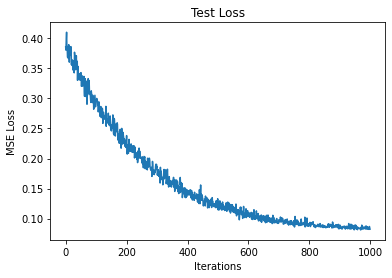

In [4]:
test_module(MultiHeadedSelfAttention(5, 5, 10, 8), (10, 10), (10, 10))

Loss is going down - we're good. 

**Feed Forward**

In [5]:
class FeedForward(nn.Module):
  def __init__(self, dim_in, dim_int, dim_out):
    super(FeedForward, self).__init__()
    self.model = nn.Sequential(nn.Linear(dim_in, dim_int), nn.ReLU(), nn.Linear(dim_int, dim_out))
  def forward(self, input):
    if len(input.shape) >= 3:
      return torch.stack([self.forward(input[i]) for i in range(len(input))])
    return self.model(input)

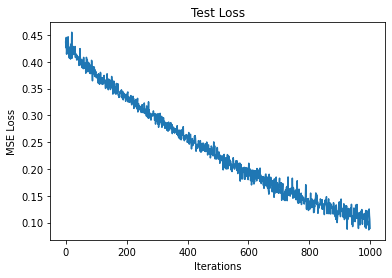

In [6]:
test_module(FeedForward(5, 20, 5), (5, 5), (5, 5))

Loss is going down - we're good. 

**Positional Encoder**

In [7]:
class PositionalEncoder():
  def __init__(self, dim):
    self.dimmodel = dim
  def encode_func(self, pos, dim):
    if dim % 2 == 0:
      return np.sin(pos/(10000**(dim/self.dimmodel)))
    else:
      return np.cos(pos/(10000**((dim-1)/self.dimmodel)))
  def encode(self, position):
    return torch.tensor([self.encode_func(position, d) for d in range(self.dimmodel)], dtype = torch.float32)

Here I instead plot out the position vectors from 1 to 512 in a heat map, and check to see if this is the expected output. 

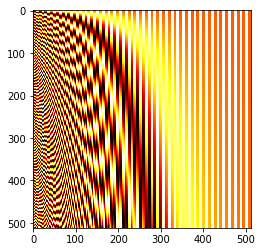

In [8]:
encode_test = PositionalEncoder(512)
mat = []
for i in range(512):
  mat.append(list(encode_test.encode(i)))
plt.imshow(mat, cmap='hot', interpolation='nearest')
plt.show()

This matches the image outputs I've seen online, so this appears to be working. 


**Encoder Block**

The encoder block is self attention with residual connections + layer norm followed by a feedforward network with residual connections + layer norm. We string a bunch of these together in the encoder. 

In [9]:
class EncoderBlock(nn.Module):
  def __init__(self, dimq, dimv, dimmodel, dim_int, num_heads):
    super(EncoderBlock, self).__init__()
    self.attention = MultiHeadedSelfAttention(dimq, dimv, dimmodel, num_heads)
    self.feedforward = FeedForward(dimmodel, dim_int, dimmodel)
    self.layernorm1 = nn.Sequential(nn.LayerNorm(normalized_shape = dimmodel), nn.Dropout(p=0.1))
    self.layernorm2 = nn.Sequential(nn.LayerNorm(normalized_shape = dimmodel), nn.Dropout(p=0.1))
  def forward(self, embeddings):
    output = self.layernorm1(embeddings+self.attention(embeddings))
    return self.layernorm2(output+self.feedforward(output))

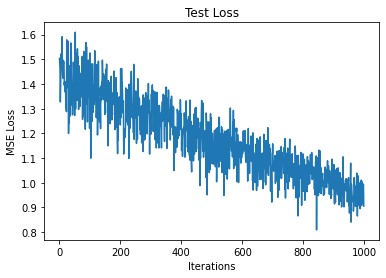

In [10]:
test_module(EncoderBlock(5, 5, 10, 20, 8), (10, 10), (10, 10))

Loss is going down - appears to be working. 

In [11]:
class Encoder(nn.Module):
  def __init__(self, dimq, dimv, dimmodel, dim_int, num_heads, num_blocks, embed_dic):
    super(Encoder, self).__init__()
    self.embed_dic = embed_dic
    self.dimmodel = dimmodel
    self.positional_encoder = PositionalEncoder(dimmodel)
    self.blocks = nn.Sequential(*[EncoderBlock(dimq, dimv, dimmodel, dim_int, num_heads) for i in range(num_blocks)])
  def getEmbed(self, token):
    if token in self.embed_dic:
      return torch.tensor(self.embed_dic[token], dtype = torch.float32)
    else:
      return torch.zeros(self.dimmodel)
  def forward(self, tokens):
    embeds = torch.stack([self.getEmbed(tokens[i])+self.positional_encoder.encode(i) for i in range(len(tokens))])
    return self.blocks(embeds)

To test this module, I had it encode sentences formed by the strings "bing" and "bong" repeated. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


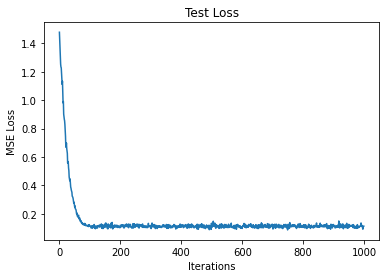

In [12]:
test_dic = {"bing":torch.rand(10), "bong":torch.rand(10)}
module = Encoder(5, 5, 10, 20, 8, 5, test_dic)
temp_optim = torch.optim.Adam(module.parameters(), lr=0.01)
loss_func = nn.MSELoss()
output = torch.rand((20, 10))
losses = []
for i in range(1000):
  temp_optim.zero_grad()
  input = []
  for j in range(20):
    if r.random() < 0.5:
      input.append("bing")
    else:
      input.append("bong")
  loss = loss_func(module(input), output)
  losses.append((float)(loss))
  loss.backward()
  temp_optim.step()
plt.title("Test Loss")
plt.ylabel("MSE Loss")
plt.xlabel("Iterations")
plt.plot(losses)

**Decoder Attention**

This is just self attention, but it takes in a second set of data representing embeddings given by the encoder. These are used to get keys/values. 

In [13]:
class DecoderAttentionHead(nn.Module):
  def __init__(self, dimq, dimv, dimmodel):
    super(DecoderAttentionHead, self).__init__()
    self.dimq = dimq
    self.dimv = dimv
    self.dimmodel = dimmodel
    self.query_proj = nn.Linear(dimmodel, dimq)
    self.key_proj = nn.Linear(dimmodel, dimq)
    self.value_proj = nn.Linear(dimmodel, dimv)
    self.softmax = nn.Softmax(dim = 0)
  def forward(self, encoder_in, decoder_in):
    queries = self.query_proj(decoder_in)
    keys = self.key_proj(encoder_in)
    values = self.value_proj(encoder_in)
    weights = self.softmax(torch.matmul(queries, torch.transpose(keys, 0, 1))/np.sqrt(self.dimq))
    return torch.matmul(weights, values)

class MultiHeadedDecoderAttention(nn.Module):
  def __init__(self, dimq, dimv, dimmodel, num_heads):
    super(MultiHeadedDecoderAttention, self).__init__()
    self.dimq = dimq
    self.dimv = dimv
    self.dimmodel = dimmodel
    self.num_heads = num_heads

    self.heads = [DecoderAttentionHead(dimq, dimv, dimmodel) for i in range(num_heads)]
    self.lin1 = nn.Linear(dimv*num_heads, self.dimmodel)
  def forward(self, encoder_in, decoder_in):
    head_embeds = torch.cat([head(encoder_in, decoder_in) for head in self.heads], dim = 1)
    return self.lin1(head_embeds)

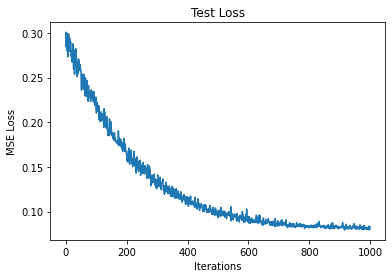

In [14]:
module = MultiHeadedDecoderAttention(5, 5, 10, 8)
temp_optim = torch.optim.Adam(module.parameters(), lr=0.0001)
loss_func = nn.MSELoss()
output = torch.rand((10, 10))
losses = []
for i in range(1000):
  temp_optim.zero_grad()
  input1 = torch.rand((10, 10))
  input2 = torch.rand((10, 10))
  loss = loss_func(module(input1, input2), output)
  losses.append((float)(loss))
  loss.backward()
  temp_optim.step()
plt.title("Test Loss")
plt.ylabel("MSE Loss")
plt.xlabel("Iterations")
plt.plot(losses)

**Masked Attention**

In retrospect, it would have been more convenient to add masked/unmasked as a parameter in self attention. Oh well. 

Here I mask by adding a tensor with negative infinities before softmax. This seemed to be a nice way to deal with this for gradient descent. 

In [15]:
class MaskedAttentionHead(nn.Module):
  def __init__(self, dimq, dimv, dimmodel):
    super(MaskedAttentionHead, self).__init__()
    self.dimq = dimq
    self.dimv = dimv
    self.dimmodel = dimmodel
    self.query_proj = nn.Linear(dimmodel, dimq)
    self.key_proj = nn.Linear(dimmodel, dimq)
    self.value_proj = nn.Linear(dimmodel, dimv)
    self.softmax = nn.Softmax(dim = 1)
  def create_mask(self, dim):
    mask = []
    for i in range(dim):
      mask.append([])
      for j in range(dim):
        if j > i:
          mask[i].append(-math.inf)
        else:
          mask[i].append(0)
    return torch.tensor(mask, dtype = torch.float32)
  def forward(self, input):
    queries = self.query_proj(input)
    keys = self.key_proj(input)
    values = self.value_proj(input)
    mask = self.create_mask(len(values))
    weights = self.softmax(torch.matmul(queries, torch.transpose(keys, 0, 1))/np.sqrt(self.dimq)+mask)
    return torch.matmul(weights, values)

class MultiHeadedMaskedAttention(nn.Module):
  def __init__(self, dimq, dimv, dimmodel, num_heads):
    super(MultiHeadedMaskedAttention, self).__init__()
    self.dimq = dimq
    self.dimv = dimv
    self.dimmodel = dimmodel
    self.num_heads = num_heads

    self.heads = [MaskedAttentionHead(dimq, dimv, dimmodel) for i in range(num_heads)]
    self.lin1 = nn.Linear(dimv*num_heads, self.dimmodel)
  def forward(self, embeddings):
    head_embeds = torch.cat([head(embeddings) for head in self.heads], dim = 1)
    return self.lin1(head_embeds)

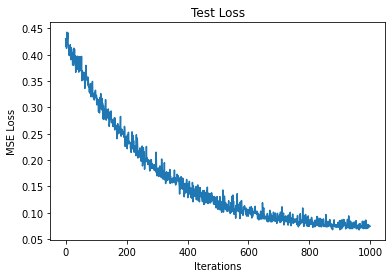

In [16]:
test_module(MultiHeadedMaskedAttention(5, 5, 10, 8), (10, 10), (10, 10))

**Decoder block**

This is masked attention follower by decoder attention followed by a feed forward, all with residual connections and layer norm. 

In [17]:
class DecoderBlock(nn.Module):
  def __init__(self, dimq, dimv, dimmodel, dim_int, num_heads):
    super(DecoderBlock, self).__init__()
    self.maskedattention = MultiHeadedMaskedAttention(dimq, dimv, dimmodel, num_heads)
    self.decoderattention = MultiHeadedDecoderAttention(dimq, dimv, dimmodel, num_heads)
    self.feedforward = FeedForward(dimmodel, dim_int, dimmodel)
    self.layernorm1 = nn.Sequential(nn.LayerNorm(normalized_shape = dimmodel), nn.Dropout(p=0.1))
    self.layernorm2 = nn.Sequential(nn.LayerNorm(normalized_shape = dimmodel), nn.Dropout(p=0.1))
    self.layernorm3 = nn.Sequential(nn.LayerNorm(normalized_shape = dimmodel), nn.Dropout(p=0.1))
  def forward(self, embeddings, encoder_in):
    output = self.layernorm1(embeddings+self.maskedattention(embeddings))
    output = self.layernorm2(output+self.decoderattention(encoder_in, output))
    return self.layernorm3(output+self.feedforward(output))

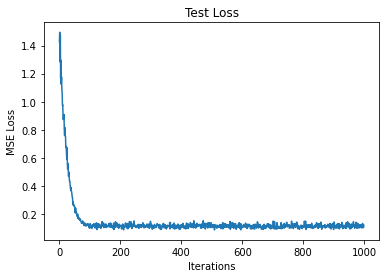

In [18]:
module = DecoderBlock(5, 5, 10, 20, 8)
temp_optim = torch.optim.Adam(module.parameters(), lr=0.01)
loss_func = nn.MSELoss()
output = torch.rand((10, 10))
losses = []
for i in range(1000):
  temp_optim.zero_grad()
  input1 = torch.rand((10, 10))
  input2 = torch.rand((10, 10))
  loss = loss_func(module(input1, input2), output)
  losses.append((float)(loss))
  loss.backward()
  temp_optim.step()
plt.title("Test Loss")
plt.ylabel("MSE Loss")
plt.xlabel("Iterations")
plt.plot(losses)

**Decoder & Transformer Modules**

Here I make the decoder and the transformer. I spend more time testing these in the next section. 

In [19]:
class Decoder(nn.Module):
  def __init__(self, dimq, dimv, dimmodel, dim_int, num_heads, num_blocks, embed_dic):
    super(Decoder, self).__init__()
    self.embed_dic = embed_dic
    self.positional_encoder = PositionalEncoder(dimmodel)
    self.dimmodel = dimmodel
    self.blocks = [DecoderBlock(dimq, dimv, dimmodel, dim_int, num_heads) for i in range(num_blocks)]
    self.prob_output = nn.Sequential(nn.Linear(dimmodel, len(embed_dic)), nn.Softmax(dim=0))
  def getEmbed(self, token):
    if token in self.embed_dic:
      return torch.tensor(self.embed_dic[token], dtype = torch.float32)
    else:
      return torch.zeros(self.dimmodel)
  def forward(self, tokens, encoder_in):
    embed_arr = [self.getEmbed(tokens[i])+self.positional_encoder.encode(i) for i in range(len(tokens))]
    embeds = torch.stack(embed_arr[:len(embed_arr)-1])
    for block in self.blocks:
      embeds = block(embeds, encoder_in)
    return self.prob_output(embeds)

In [20]:
class Transformer(nn.Module):
  def __init__(self, dimq, dimv, dimmodel, dim_int, num_heads, num_blocks, embed_dic_in, embed_dic_out):
    super(Transformer, self).__init__()
    self.encoder = Encoder(dimq, dimv, dimmodel, dim_int, num_heads, num_blocks, embed_dic_in)
    self.decoder = Decoder(dimq, dimv, dimmodel, dim_int, num_heads, num_blocks, embed_dic_out)
  def forward(self, tokens_in, tokens_out):
    encoded_embeds = self.encoder(tokens_in)
    return self.decoder(tokens_out, encoded_embeds)

And we're done. 

Things I learned from implementing transformers that I didn't know from having a high level overview of how they worked:
- I thought each self-attention layer learned its own queries, values, and keys from scratch, and stored them in different dictionaries, similar to word2vec (where keys are individual words/tokens). However, they actually find these from the previous embeddings via applying a linear transformation. This seems like a pretty good thing to know. 
- You only add the positional encodings at the beginning of an encoder, and not in each head or each encoder block. 
- You used different kinds of attention heads in the Decoder and Encoder. I didn't realize there were types of attention other than self-attention.
- I figured out how to interpret how we translate information from encoder to decoder in translation tasks: you set the keys and values to those of the previous sentence, so the queries "sent" by the translated words "look" at the untranslated sentence. 

- Transformers have to use layer norm instead of batch norm, since sentences are different lengths. 
- I figured out how to do a for loop within nn.sequential. Seems useful. 
- I learned how to mask values by setting them to negative infinity in ways that are convenient for torch's gradient: add a vector with negative infinity values before softmax. 
- Got experiencing debugging more complicated models - e.g., by implementing separate components first and testing these before testing the entire model. 

# Testing

I now test the model with the following small task:

"bing" and "bong" are the only words in language 2, and "beep" and "boop" are the only words in language 1. To translate between them, "bing" translates to "beep boop beep" and "bong" translates to "beep beep boop boop". We want to translate from language 1 to language 2, NOT language 2 to language 1. 

I think this tests a transformer's ability to learn simple translation algorithms.  

In [39]:
def make_data(embed_dic_in, embed_dic_out, inputs, outputs, tokenizer_in, tokenizer_out):
  corpus_out = [i for i in embed_dic_out]
  idx_dic_out = {corpus_out[i]:i for i in range(len(corpus_out))}
  in_tokens = [tokenizer_in(sentence) for sentence in inputs]
  out_tokens = [tokenizer_out(sentence) for sentence in outputs]
  out_idx = [[idx_dic_out[token] for token in token_list] for token_list in out_tokens]
  data = [(in_tokens[i], out_tokens[i], torch.tensor(out_idx[i][1:])) for i in range(len(inputs))]
  return data

def make_batches(data, bs=20):
  batches = []
  for idx in range(0, len(data), bs):
    batches.append(data[idx:min(idx + bs, len(data))])
  return batches

In [40]:
# I make embeddings random
language_1_dic = {"BOS":np.random.rand(10), "beep":np.random.rand(10), "boop":np.random.rand(10), "EOS":np.random.rand(10)}
language_2_dic = {"BOS":np.random.rand(10), "bing":np.random.rand(10), "bong":np.random.rand(10), "EOS":np.random.rand(10)}
train_acc = []
test_acc = []

I'm generating train/test data by randomly generating strings in the second language and converting them to the first language. 

In [41]:
def split_tokenizer(st):
  return st.split(" ")
def conversion_rule(string1):
  return string1.replace("bing", "beep boop beep").replace("bong", "beep beep boop boop")
def generate_data(size, bs = 20):
  inputs = []
  outputs = []
  for i in range(size):
    example_length = r.randint(1, 10)
    out = "BOS "
    for j in range(example_length):
      if r.random() < 0.5:
        out += "bing "
      else:
        out += "bong "
    out += "EOS"
    outputs.append(out)
    inputs.append(conversion_rule(out))
  return make_batches(make_data(language_1_dic, language_2_dic, inputs, outputs, split_tokenizer, split_tokenizer), bs)

In [42]:
def run_epoch(batched_data, model, loss_func, optimizer, loss_list = []):
  for batch in batched_data:
    optimizer.zero_grad()
    predictions = torch.concat([model(input1, input2) for (input1, input2, _) in batch], axis = 0)
    actuals = torch.concat([output for (_, _, output) in batch], axis = 0)
    loss = loss_func(predictions, actuals)
    loss_list.append((float)(loss))
    loss.backward()
    optimizer.step()
  return loss_list
def get_accuracy(data, model):
  corrects = []
  for batch in data:
    for (input1, input2, output) in batch:
      preds = np.argmax(np.array(model(input1, input2).detach()), axis = 1)
      actuals = np.array(output)
      corrects += [preds[i] == actuals[i] for i in range(len(actuals))]
  return sum(corrects)/len(corrects)

Here I train the transformer. 

In [50]:
model = Transformer(5, 5, 10, 20, 2, 2, language_1_dic, language_2_dic)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()
train_data = generate_data(800)
test_data = generate_data(200)
losses = []
print("Initial train accuracy: ", get_accuracy(train_data, model))
print("Initial test accuracy: ", get_accuracy(test_data, model))

Initial train accuracy:  0.21060722521137587
Initial test accuracy:  0.22695584817970565


In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
for i in range(100000):
  run_epoch(train_data, model, loss_func, optimizer, losses)
  if i % 100 == 0:
    plt.plot(moving_average(losses, 40))
    plt.show()

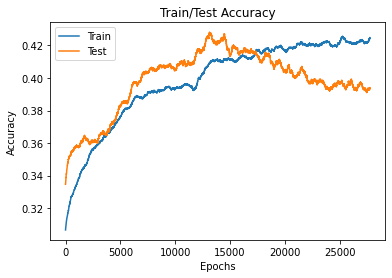

In [46]:

plt.title("Train/Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.plot(moving_average(train_acc, 500))
plt.plot(moving_average(test_acc, 500))
plt.legend(["Train", "Test"])
plt.show()

Turns out it takes forever to learn even a simple task like this, and my model is overfitting (probably should have included more data). 